In [1]:
import numpy as np 
import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from pytorch_lightning import Trainer

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from dataset import MushroomBodyDataset 
from rnn import NeuralRNNModule, NeuralRNN

%load_ext autoreload
%aimport dataset, rnn
%autoreload 1

In [2]:
dataset = MushroomBodyDataset()

print(f'Datum shape for input and output is (timesteps, neurons): {dataset[0]["dan"].shape}')
# dataset.data[0]

Datum shape for input and output is (timesteps, neurons): torch.Size([10, 15])


In [3]:
num_samples = len(dataset.data)
train_percentage, val_percentage = 0.6, 0.2
test_percentage = 1 - train_percentage - val_percentage

lengths = [
    int(train_percentage * num_samples), 
    int(val_percentage * num_samples),
    int(test_percentage * num_samples),
]

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))

print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 5400
Val dataset size: 1800
Test dataset size: 1800


# Hyperparams

In [4]:
hparams = {
    'batch_size': 8,
    'lr': 0.001,
    'max_epochs': 10,
    'min_epochs': 1
}

# Create Dataloaders

In [5]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=hparams['batch_size'],
    shuffle=False, 
    num_workers=4
)

# Instantiate Model

In [6]:
model = NeuralRNNModule(
    input_dim=15,
    hidden_dim=15, 
    lr=hparams['lr']
)

In [7]:
batch = next(iter(train_dataloader))

In [8]:
# Check that the forward pass does what I expect
output = model(batch['dan'])
output.shape

torch.Size([8, 10, 15])

# Lets Try Train

In [9]:
logger = TensorBoardLogger("tb_logs", name="rnn", default_hp_metric=False)

In [10]:
logger.log_hyperparams(hparams)

In [11]:
trainer = Trainer(
    logger=logger,
    max_epochs=hparams['max_epochs'],
    min_epochs=hparams['min_epochs'],
    callbacks=[EarlyStopping(monitor='val/loss')]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [12]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name     | Type      | Params
---------------------------------------
0 | rnn      | NeuralRNN | 480   
1 | loss_fcn | MSELoss   | 0     
---------------------------------------
480       Trainable params
0         Non-trainable params
480       Total params
0.002     Total estimated model params size (MB)


Epoch 0:  75%|███████▌  | 675/900 [00:11<00:03, 58.88it/s, loss=0.00339, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 1:  75%|███████▌  | 675/900 [00:10<00:03, 65.47it/s, loss=0.00239, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 2:  75%|███████▌  | 675/900 [00:09<00:03, 68.36it/s, loss=0.00212, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 3:  75%|███████▌  | 675/900 [00:10<00:03, 64.62it/s, loss=0.002, v_num=1]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  75%|███████▌  | 675/900 [00:13<00:04, 49.81it/s, loss=0.00192, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 5:  75%|███████▌  | 675/900 [00:15<00:05, 42.51it/s, loss=0.00187, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 6:  75%|███████▌  | 675/900 [00:09<00:03, 72.93it/s, loss=0.00184, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 7:  75%|███████▌  | 675/900 [00:14<00:04, 45.82it/s, loss=0.00182, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 8:  75%|███████▌  | 676/900 [00:09<00:03, 72.77it/s, loss=0.0018, v_num=1] 
Validating: 0i

# Visualise the trained weights

In [13]:
import matplotlib.pyplot as plt

lobes = ["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5']
greek_lobes = [r"$\alpha '_1$", r"$\alpha '_2$", r"$\alpha '_3$", 
              r"$\alpha _1$", r"$\alpha _2$", r"$\alpha_3$",
              r"$\beta '_1$", r"$\beta '_2$", r"$\beta _1$", r"$\beta _2$",
              r"$\gamma _1$", r"$\gamma _2$", r"$\gamma _3$", r"$\gamma _4$", r"$\gamma _5$", ]

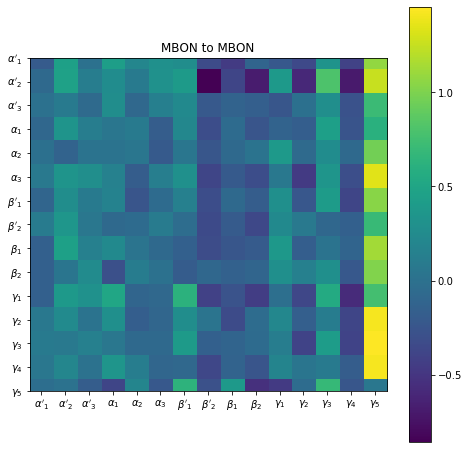

In [14]:
plt.figure(figsize=[8,8])
plt.imshow(model.rnn.W_hh.weight.detach().numpy())
plt.colorbar()
plt.xticks(range(0,15), greek_lobes)
plt.yticks(range(0,15), greek_lobes)
plt.title('MBON to MBON')
plt.show()

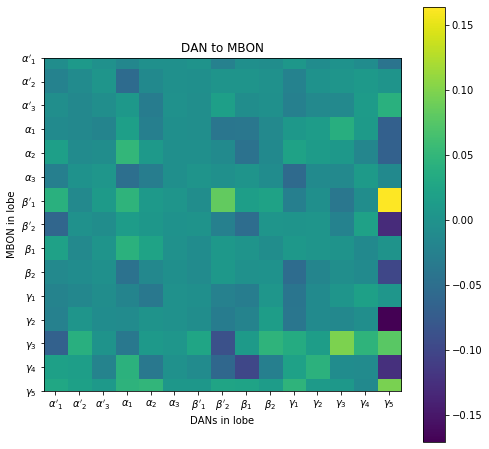

In [15]:
plt.figure(figsize=[8,8])
plt.imshow(model.rnn.W_xh.weight.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.xticks(range(0,15), greek_lobes)
plt.yticks(range(0,15), greek_lobes)

plt.title('DAN to MBON')
plt.xlabel('DANs in lobe')
plt.ylabel('MBON in lobe')
plt.show()

In [16]:
 model.eval()

NeuralRNNModule(
  (rnn): NeuralRNN(
    (W_xh): Linear(in_features=15, out_features=15, bias=True)
    (W_hh): Linear(in_features=15, out_features=15, bias=True)
    (activation): Tanh()
  )
  (loss_fcn): MSELoss()
)

In [18]:
batch = next(iter(train_dataloader))
output = model(batch['dan'])

print(output.shape)

torch.Size([8, 10, 15])


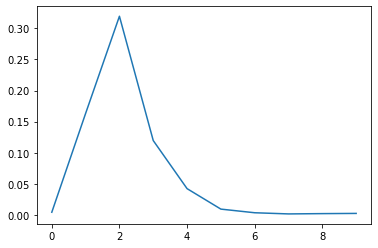

In [21]:
plt.plot(output[0,:,0].detach().numpy() )